In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jena-climate/jena_climate_2009_2016.csv
/kaggle/input/dataset-1-and-2/AQI_ex.csv
/kaggle/input/dataset-1-and-2/seoul_ex.csv


In [31]:
# Loss function with improved accuracy - Seoul Dataset

# After removing date from input
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [32]:
# Modify the load_and_preprocess_data function to also return dates
def load_and_preprocess_data(file_path, sequence_length=60):
    # Load data
    data = pd.read_csv(file_path)
    
    # Store the date column and drop it from input data
    dates = pd.to_datetime(data.iloc[:, 0])
    data = data.iloc[:, 1:]
    
    # Convert non-numeric columns, such as dates
    for col in data.columns:
        if data[col].dtype == 'object':
            try:
                data[col] = pd.to_datetime(data[col], errors='coerce')
                data[col] = data[col].map(lambda x: x.toordinal() if not pd.isnull(x) else np.nan)
            except:
                data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Drop rows with any NaN values after conversion
    data = data.dropna()
    dates = dates[data.index]  # Keep only corresponding dates
    
    # Scale data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences
    X, y, date_seq = [], [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(data_scaled[i])
        date_seq.append(dates.iloc[i])  # Capture the corresponding date for each y
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler, np.array(date_seq)


In [33]:
# Load data and obtain the date sequences
X_seoul, y_seoul, scaler_seoul, date_seoul = load_and_preprocess_data('/kaggle/input/dataset-1-and-2/seoul_ex.csv')


In [34]:
# Define LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(y_seoul.shape[1]))  # Ensure output shape matches y dimension
    return model

input_shape = (X_seoul.shape[1], X_seoul.shape[2])
model_custom = create_model(input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# Define Custom Loss Function with Dynamic Smoothness
# Modified Custom Loss Function with Gradient-Based Smoothness Penalty and Adaptive Weight Control
# Refined Custom Loss Function with Moving Average Smoothing and Reduced Weight
class CustomLossV3(tf.keras.losses.Loss):
    def __init__(self, initial_smoothness_weight=0.01, alpha=0.5):
        super().__init__()
        self.smoothness_weight = initial_smoothness_weight
        self.initial_smoothness_weight = initial_smoothness_weight
        self.alpha = alpha  # Weight for combining MAE and MSE

    def call(self, y_true, y_pred):
        # Weighted combination of MAE and MSE
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        combined_error = self.alpha * mae + (1 - self.alpha) * mse

        # Moving average smoothness penalty over the last three predictions
        smoothness_penalty = 0
        if y_pred.shape[1] > 2:
            moving_avg_diff = tf.reduce_mean(
                tf.square(y_pred[:, 2:] - (y_pred[:, 1:-1] + y_pred[:, :-2]) / 2)
            )
            smoothness_penalty = moving_avg_diff

        # Adaptive weight for smoothness penalty using slower decay
        adaptive_weight = self.initial_smoothness_weight * tf.exp(-0.001 * self.smoothness_weight)
        total_loss = combined_error + adaptive_weight * smoothness_penalty

        # Update smoothness weight more gradually
        self.smoothness_weight += 0.005

        return total_loss



# Compile model with custom loss
custom_loss = CustomLossV3()


In [36]:
# Update the train_and_evaluate_with_plot function to include prediction plotting
def train_evaluate_plot_predictions(model, X, y, dates, scaler, loss_function, loss_name, epochs=50, batch_size=32):
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    
    # Inverse transform predictions and true values
    y_pred_original = scaler.inverse_transform(y_pred)
    y_true_original = scaler.inverse_transform(y)
    
    print(f"The accuracy using {loss_name} - MAE: {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{loss_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot predicted vs. true values over time
    plt.figure(figsize=(15, 6))
    plt.plot(dates, y_true_original[:, 0], label='True Value', color='blue')
    plt.plot(dates, y_pred_original[:, 0], label='Predicted Value', color='orange')
    plt.title(f'{loss_name} - Predicted vs. True Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    return [mae,mse,rmse,r2]


Training with Custom Loss...
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0289 - mae: 0.0490
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - mae: 0.0464
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0273 - mae: 0.0462
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0272 - mae: 0.0460
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - mae: 0.0456
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - mae: 0.0457
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - mae: 0.0456
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0270 - mae: 0.0459
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0271 - mae: 0.0459
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - mae: 0.0456
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0273 - mae: 0.0462
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0269 - mae: 0.0455
Epoch 13/50
44/44 ━━

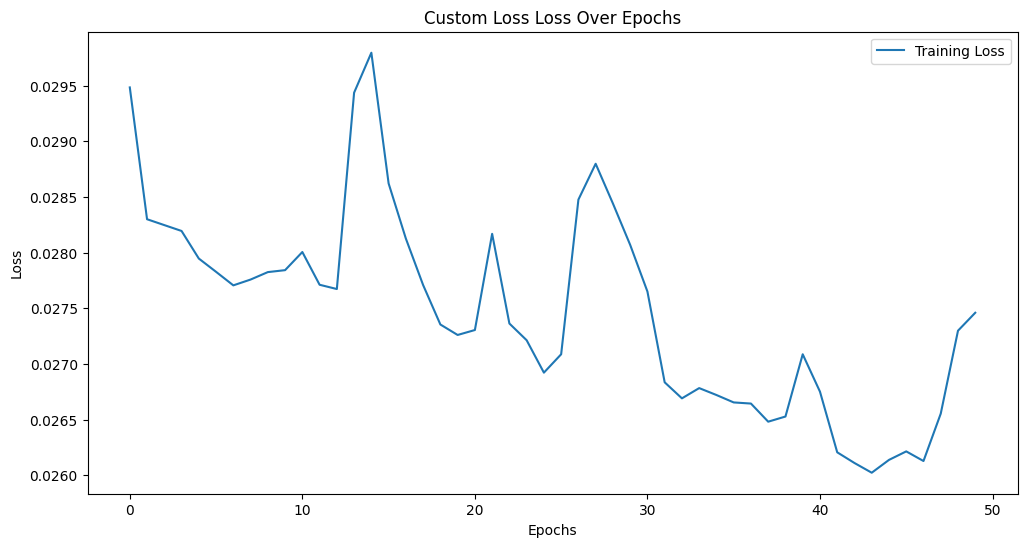

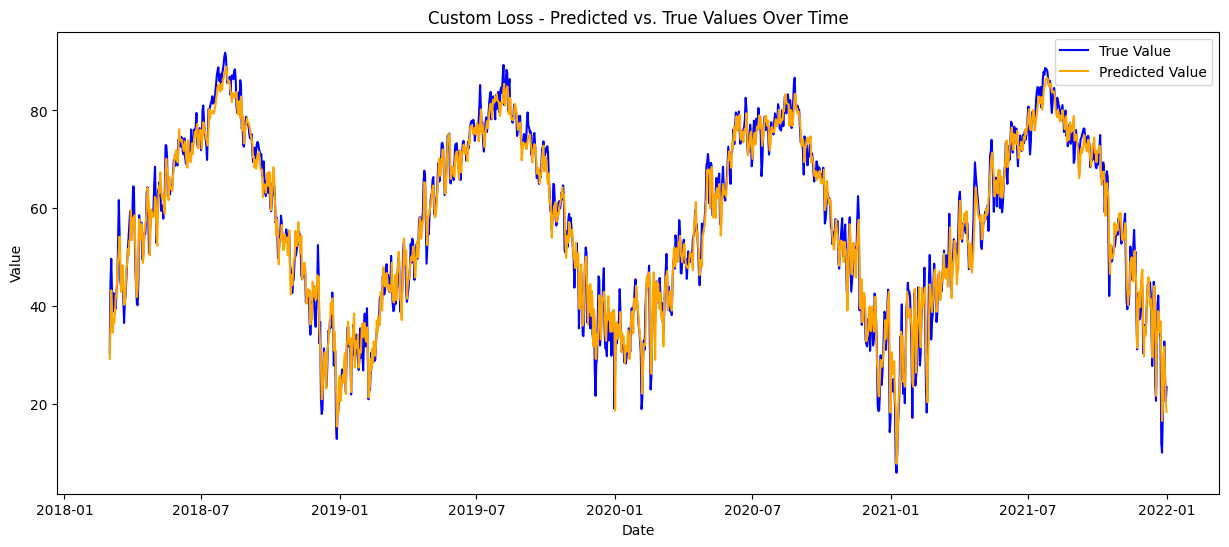

In [40]:
    # Training and plotting with custom loss
    print("Training with Custom Loss...")
    [mae_custom,mse_custom,rmse_custom,r2_custom] = train_evaluate_plot_predictions(model_custom, X_seoul, y_seoul, date_seoul, scaler_seoul, custom_loss, "Custom Loss", epochs=50)
    model_custom.save("model_custom_loss.h5")  # Save the model with custom loss

Training with Mean Squared Error Loss...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1348 - mae: 0.2764
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0271 - mae: 0.1183
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0240 - mae: 0.1097
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0193 - mae: 0.0992
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0169 - mae: 0.0933
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - mae: 0.0907
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - mae: 0.0870
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 - mae: 0.0813
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - mae: 0.0805
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - mae: 0.0768
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mae: 0.0743
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mae: 0.0719
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

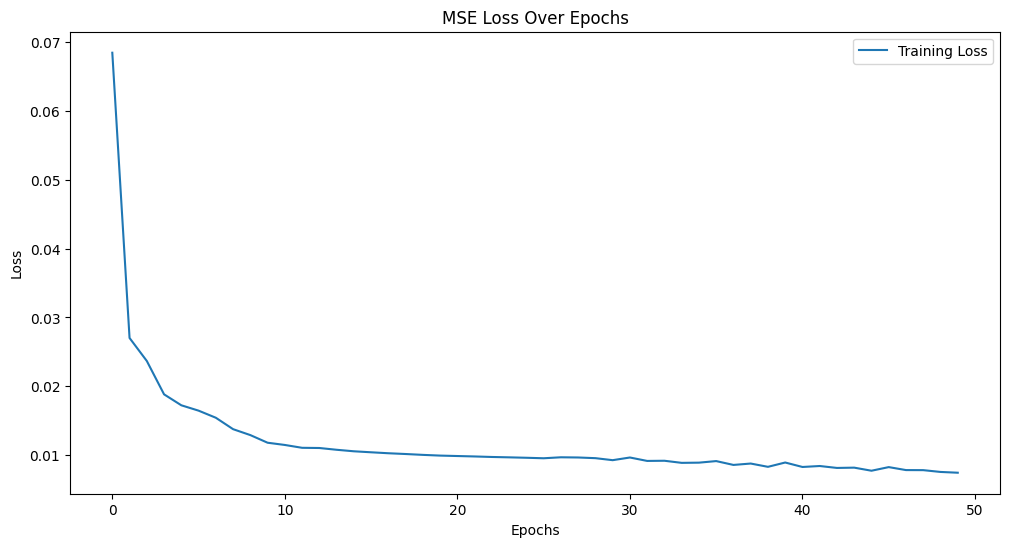

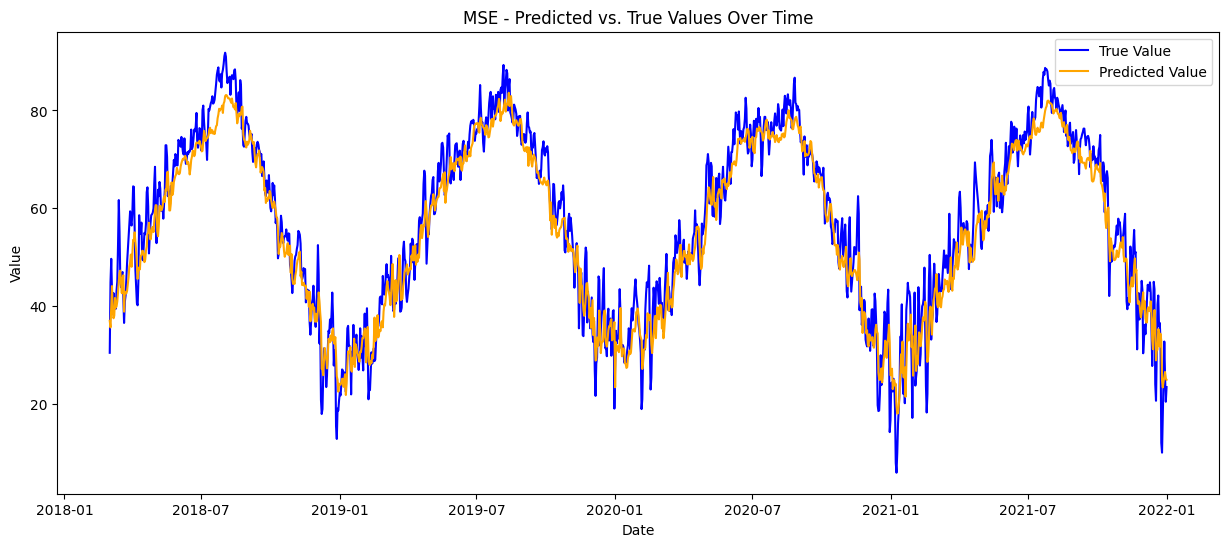

In [41]:
# Recreate model for MSE to ensure independent training
model_mse = create_model(input_shape)

# Training and plotting with MSE loss
print("Training with Mean Squared Error Loss...")
[mae_mse,mse_mse,rmse_mse,r2_mse] = train_evaluate_plot_predictions(model_mse, X_seoul, y_seoul, date_seoul, scaler_seoul, 'mse', "MSE")
model_mse.save("model_mse_loss.h5")  # Save the model with MSE loss

Training with Mean Absolute Error Loss...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2468 - mae: 0.2468
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1167 - mae: 0.1167
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1094 - mae: 0.1094
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0953 - mae: 0.0953
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0909 - mae: 0.0909
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0877 - mae: 0.0877
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0799 - mae: 0.0799
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0779 - mae: 0.0779
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0767 - mae: 0.0767
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0769 - mae: 0.0769
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0754 - mae: 0.0754
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0713 - mae: 0.0713
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

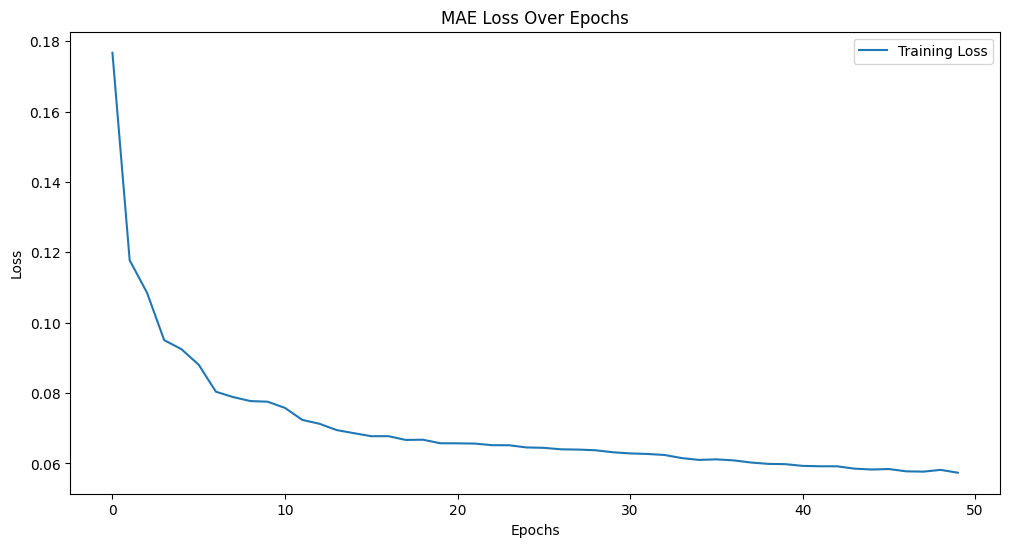

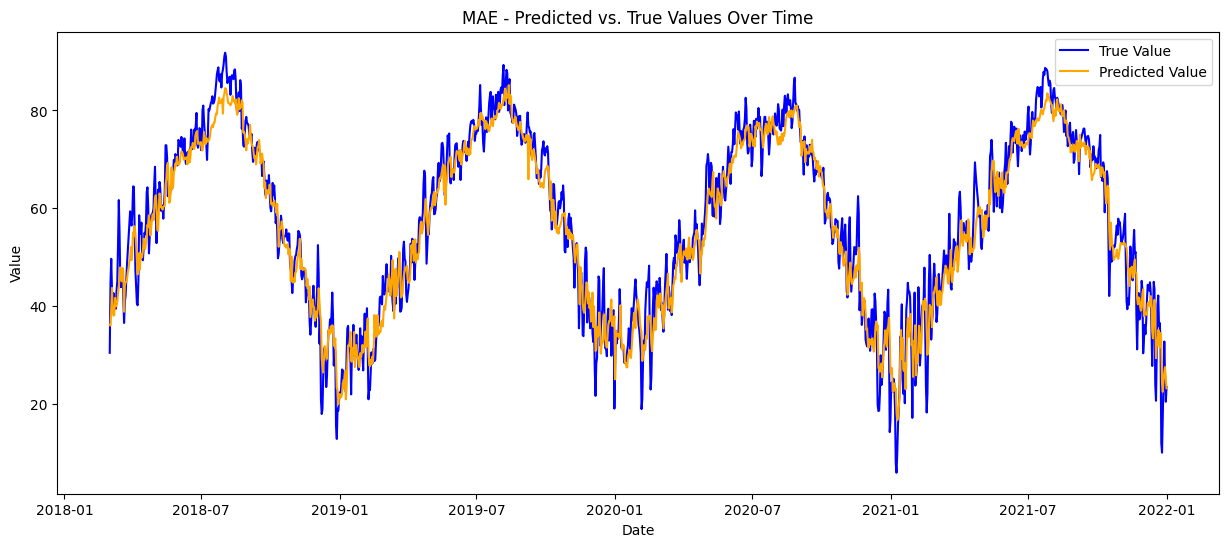

In [42]:
# Recreate model for MAE to ensure independent training
model_mae = create_model(input_shape)

# Training and plotting with MAE loss
print("Training with Mean Absolute Error Loss...")
[mae_mae, mse_mae, rmse_mae, r2_mae] = train_evaluate_plot_predictions(model_mae, X_seoul, y_seoul, date_seoul, scaler_seoul, 'mae', "MAE")
model_mae.save("model_mae_loss.h5")  # Save the model with MAE loss

Training with Huber Loss...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0419 - mae: 0.2166
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mae: 0.1205
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mae: 0.1113
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - mae: 0.0940
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mae: 0.0888
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0825
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mae: 0.0794
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mae: 0.0786
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0755
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0729
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mae: 0.0708
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mae: 0.0699
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

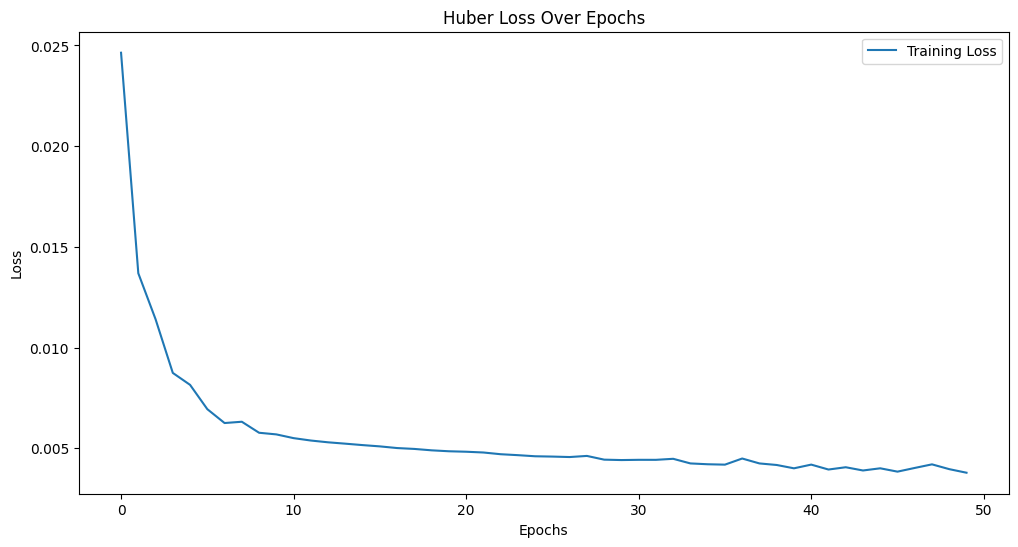

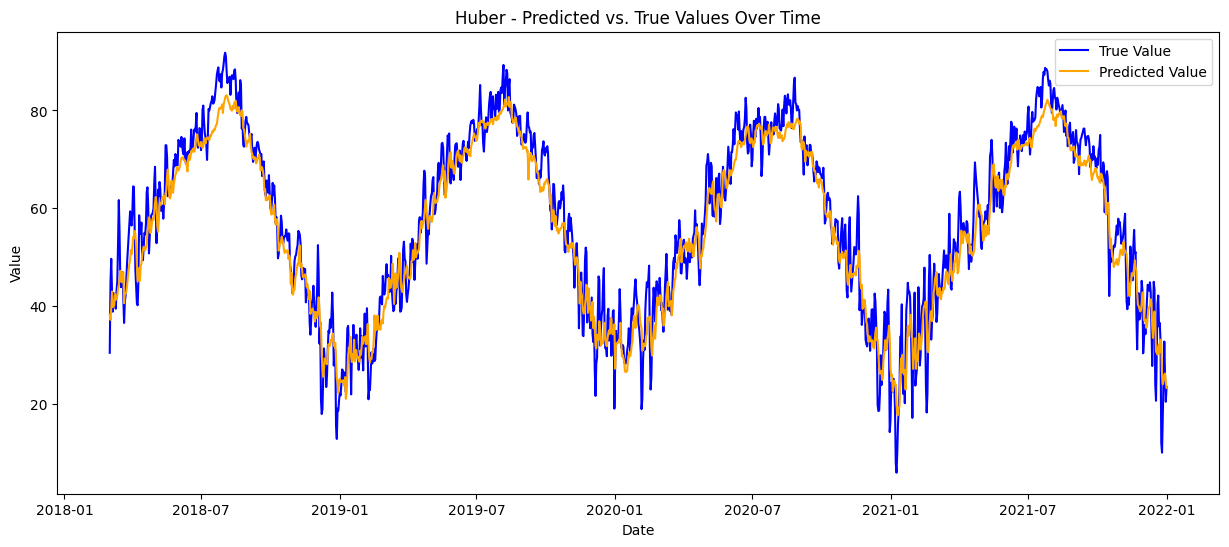

In [48]:
# Recreate model for MSE to ensure independent training
model_huber = create_model(input_shape)

# Training and plotting with Huber loss
print("Training with Huber Loss...")
[mae_huber, mse_huber, rmse_huber, r2_huber] = train_evaluate_plot_predictions(model_huber, X_seoul, y_seoul, date_seoul, scaler_seoul, tf.keras.losses.Huber, "Huber")
# model_huber.save("model_huber_loss.h5")  # Save the model with Huber loss


In [49]:
# Compare Results

print("\nComparison of MAE for Loss Functions:")
print(f"The accuracy using Custom Loss - MAE: {mae_custom:.4f}")
print(f"The accuracy using MSE Loss - MAE: {mae_mse:.4f}")
print(f"The accuracy using MAE Loss - MAE: {mae_mae:.4f}")
print(f"The accuracy using Huber Loss - MAE: {mae_huber:.4f}")

print("\nComparison of MSE for Loss Functions:")
print(f"The accuracy using Custom Loss - MSE: {mse_custom:.4f}")
print(f"The accuracy using MSE Loss - MSE: {mse_mse:.4f}")
print(f"The accuracy using MAE Loss - MSE: {mse_mae:.4f}")
print(f"The accuracy using Huber Loss - MSE: {mse_huber:.4f}")

print("\nComparison of RMSE for Loss Functions:")
print(f"The accuracy using Custom Loss - RMSE: {rmse_custom:.4f}")
print(f"The accuracy using MSE Loss - RMSE: {rmse_mse:.4f}")
print(f"The accuracy using MAE Loss - RMSE: {rmse_mae:.4f}")
print(f"The accuracy using Huber Loss - RMSE: {rmse_huber:.4f}")

print("\nComparison of R2 for Loss Functions:")
print(f"The accuracy using Custom Loss - R2: {r2_custom:.4f}")
print(f"The accuracy using MSE Loss - R2: {r2_mse:.4f}")
print(f"The accuracy using MAE Loss - R2: {r2_mae:.4f}")
print(f"The accuracy using Huber Loss - R2: {r2_huber:.4f}")




Comparison of MAE for Loss Functions:
The accuracy using Custom Loss - MAE: 0.0469
The accuracy using MSE Loss - MAE: 0.0590
The accuracy using MAE Loss - MAE: 0.0561
The accuracy using Huber Loss - MAE: 0.0595

Comparison of MSE for Loss Functions:
The accuracy using Custom Loss - MSE: 0.0055
The accuracy using MSE Loss - MSE: 0.0072
The accuracy using MAE Loss - MSE: 0.0079
The accuracy using Huber Loss - MSE: 0.0074

Comparison of RMSE for Loss Functions:
The accuracy using Custom Loss - RMSE: 0.0744
The accuracy using MSE Loss - RMSE: 0.0848
The accuracy using MAE Loss - RMSE: 0.0891
The accuracy using Huber Loss - RMSE: 0.0861

Comparison of R2 for Loss Functions:
The accuracy using Custom Loss - R2: 0.7049
The accuracy using MSE Loss - R2: 0.6507
The accuracy using MAE Loss - R2: 0.6139
The accuracy using Huber Loss - R2: 0.6458
